In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy
from IPython.display import clear_output

In [2]:
txt='''#############
#...........#
###B#C#B#D###
  #A#D#C#A#
  #########'''

In [3]:
text_tablon=[(x+'##').replace(' ','#') if len(x)==11 else x.replace(' ','#') for x in txt.split('\n')]


In [4]:
map_chars={'#':255,'.':0,'A':40,'B':80,'C':120,'D':160}
motion_cost={40:1,
             80:10,
             120:100,
             160:1000}


In [5]:
int_map=np.array([np.array([map_chars[y] for y in list(x)]) for x in text_tablon])

In [6]:
goal_position={v:p for v,p in zip([40,80,120,160],np.where(((int_map<255)&(int_map>0)).sum(axis=0))[0])}

In [7]:
parking_category={goal_position[k]:k for k in goal_position.keys()}

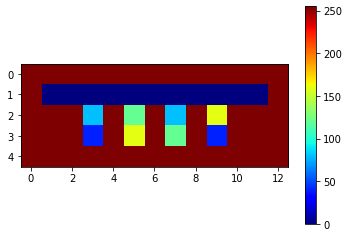

In [8]:

plt.imshow(int_map)
plt.set_cmap('jet')
plt.colorbar()

In [9]:
posicions_jugables=[[1,1],[1,2],[1,4],[1,6],[1,8],[1,10],[1,11],[2,3],[3,3],[2,5],[3,5],[2,7],[3,7],[2,9],[3,9]]


In [10]:
def get_camino (from_pos,to_pos):
    
    if from_pos==to_pos:
        return []
    else:
        camino=[]
        pto_actual=from_pos
        if from_pos[0]>1: #inside parking
            if from_pos[1]==to_pos[1]: # same parking
                if from_pos[0]<to_pos[0]:
                    camino=[[y,from_pos[1]] for y in range(from_pos[0]+1,to_pos[0]+1)]
                else:
                    camino=[[y,from_pos[1]] for y in range(from_pos[0]-1,to_pos[0]-1,-1)]
            else:
                if to_pos[0]==1:
                    camino=get_camino(from_pos,[1,from_pos[1]])+get_camino([1,from_pos[1]],to_pos)
                else:
                    camino=get_camino(from_pos,[1,from_pos[1]])+get_camino([1,from_pos[1]],[1,to_pos[1]])+get_camino([1,to_pos[1]],to_pos)
        else: # from_pos [0]==1
            if to_pos[0]==1:
                if from_pos[1]<to_pos[1]:
                    camino=[[1,x] for x in range(from_pos[1]+1,to_pos[1]+1)]
                else:
                    camino=[[1,x] for x in range(from_pos[1]-1,to_pos[1]-1,-1)]
            else:
                if from_pos[1]==to_pos[1]:
                    camino=[[y,from_pos[1]] for y in range(from_pos[0]+1,to_pos[0]+1)]
                else:
                    camino=get_camino(from_pos,[1,to_pos[1]])+get_camino([1,to_pos[1]],to_pos)
                
    return camino

def coste_camino(mapa,from_pos,to_pos):
    camino=get_camino (from_pos,to_pos)
    return len(camino)*motion_cost[mapa[from_pos[0],from_pos[1]]]


In [11]:

def identify_motion_sources_new(mapa):
    # fichas que tengan un 0 
    valid_sources=[]
    for y in range(mapa.shape[0]):
        for x in range(mapa.shape[1]):
            if (mapa[y,x]>0) & (mapa[y,x]<255):
                if (mapa[y+1,x]==0) | (mapa[y-1,x]==0) | (mapa[y,x+1]==0)  | (mapa[y,x-1]==0) :
                    if y==1:
                        valid_sources.append([y,x])
                    else:
                        if ((y==3) or (y==2)) and mapa[y,x]!=parking_category[x]:
                            valid_sources.append([y,x])
                        elif (y==2) and (mapa[3,x]!=parking_category[x]):
                                valid_sources.append([y,x])
                
    return valid_sources

def identify_motion_sources(mapa):
    # fichas que tengan un 0 
    valid_sources=[]
    for y in range(mapa.shape[0]):
        for x in range(mapa.shape[1]):
            if (mapa[y,x]>0) & (mapa[y,x]<255):
                if (mapa[y+1,x]==0) | (mapa[y-1,x]==0) | (mapa[y,x+1]==0)  | (mapa[y,x-1]==0) :
                    if y==1:
                        valid_sources.append([y,x])
                    else:
                        if ((y==3) or (y==2)) and mapa[y,x]!=parking_category[x]:
                            valid_sources.append([y,x])
                        elif (y==2) and (mapa[3,x]!=parking_category[x]):
                                valid_sources.append([y,x])
                
    return valid_sources
                    

    

    
def goal(mapa):
    ret_val=True
    for parking in goal_position.keys():
        ret_val=ret_val & (mapa[2,goal_position[parking]]==parking) & (mapa[3,goal_position[parking]]==parking)
    return ret_val

def is_valid_motion(mapa,from_pos,to_pos):
    valid_motion=True
    
    category=mapa[from_pos[0],from_pos[1]]
    valid_motion=(category>0)& (category<255) # mueve una posicion con ficha
    
    
    if (to_pos==from_pos):
            valid_motion=False
        
    if (to_pos[0]==1):
        if to_pos[1] in [3,5,7,9]:  # no puede ir a bloquear entrada parking
            valid_motion=False
            
        if from_pos[0]==1: # si estoy en el pasillo solo puedo moverme para entrar en parking
            valid_motion=False
    
    if to_pos[0]>1: # quiero entrar en parquing
        
        if (from_pos[0]>1) and (from_pos[1]==goal_position[category]): # si ya estoy en mi parking no puedo moverme a otra posicion de mi parking
            valid_motion=False
            
        if (to_pos[1]!=goal_position[category]): # solo puede entrar en parking del propio color
            valid_motion=False
        
        if (to_pos[0]==2) and (to_pos[1]==goal_position[category]) and (mapa[3,to_pos[1]]!=category): # no puedo ir a mi parquing si esta ocupado por un bicho de otro color
            valid_motion=False
                        
    
    if valid_motion:
        camino=get_camino(from_pos,to_pos) # el camino no tiene que estar bloqueado por otra ficha
        for p in camino:
            if mapa[p[0],p[1]]!=0:
                valid_motion=False
        
    return valid_motion

def get_valid_movimientos(mapa):
    sources=identify_motion_sources(mapa)
    movimientos=[]
    for src in sources:
        movimientos+=[[src,dst] for dst in posicions_jugables if is_valid_motion (mapa,src,dst)]
    return movimientos
    
    
def move(mapa,from_pos,to_pos):
    valid_motion=is_valid_motion(mapa,from_pos,to_pos)
    
    new_mapa=mapa.copy()
        
    if valid_motion:
        new_mapa[to_pos[0],to_pos[1]]=new_mapa[from_pos[0],from_pos[1]]
        new_mapa[from_pos[0],from_pos[1]]=0
    return valid_motion,new_mapa
    

In [164]:
def minim_distance_to_goal(mapa):
    #dado un mapa retorna cota inferior de coste para llegar a goal
    #usado para podar ramas del arbol de soluciones
    coste=0
    for color,posicion_parking_x in zip([40,80,120,160],[3,5,7,9]):
        posiciones=np.where(mapa==color)
        coste+=coste_camino(mapa,[posiciones[0][0],posiciones[1][0]],[3,posicion_parking_x])
        coste+=coste_camino(mapa,[posiciones[0][1],posiciones[1][1]],[2,posicion_parking_x])
    return coste

def parking_fitness(mapa):
    coste=0
    for color,posicion_parking_x in zip([40,80,120,160],[3,5,7,9]):
        posiciones=np.where(mapa==color)
        if posiciones[1][0]>1:
            coste+=coste_camino(mapa,[posiciones[0][0],posiciones[1][0]],[3,posicion_parking_x])
        if posiciones[1][1]>1:
            coste+=coste_camino(mapa,[posiciones[0][1],posiciones[1][1]],[2,posicion_parking_x])
    return coste
    

In [13]:
posiciones_parkings=[x for x in posicions_jugables if x[0]>1]
def actualizar_camino_con_movimientos_directos(camino):
    
    continuar=True
    while continuar:
        continuar=False
        sources=[x for x in identify_motion_sources(camino['mapa_final']) ]
        if len(sources):
            for src in sources:
                movimientos=[[src,dst] for dst in posiciones_parkings if is_valid_motion (camino['mapa_final'],src,dst)]
                if len(movimientos):
                    continuar=True
                for movimiento in movimientos:
                    src=movimiento[0]
                    dst=movimiento[1]

                    if len(camino['camino'])==0:
                        camino['camino']=[[src,dst]]
                    else:
                        camino['camino']+=[[src,dst]]
                    camino['coste']+=coste_camino(camino['mapa_final'],src,dst)
                    valid,camino['mapa_final']=move(camino['mapa_final'],src,dst)
                    camino['coste_restante_minimo']=minim_distance_to_goal(camino['mapa_final'])
                
                                    
    

In [218]:
mapa=int_map


In [219]:
solucion={'camino':[],
         'mapa_final':mapa,
         'coste':0,
         'coste_restante_minimo':minim_distance_to_goal(mapa),
         'parking_fitness':parking_fitness(mapa)}
solucion['hash']=hash(str(solucion['mapa_final']))

caminos=[solucion]

In [220]:
anterior=None

coste_restante=None
winners=[]


In [221]:
#def expandir_caminos(caminos):
#  determinar que camino tengo que expandir
continuar=True
while continuar:
    caminos_terminados=[x['coste']  for x in caminos if x['coste_restante_minimo']==0]
    if len(caminos_terminados):
        coste_caminos_optimo=min(caminos_terminados)
        print(coste_caminos_optimo)
    else:
        coste_caminos_optimo=999999999

    #caminos_no_terminados=[[i,x['coste_restante_minimo']+x['coste']] for i,x in enumerate(caminos) if x['coste_restante_minimo']>0]
    caminos_no_terminados=[[i,x['coste_restante_minimo']] for i,x in enumerate(caminos) if x['coste_restante_minimo']>0]

    if len(caminos_no_terminados):
        winner=caminos_no_terminados[np.argmin(x[1] for x in caminos_no_terminados)][0]
        
        camino=copy.deepcopy(caminos[winner])
        if True:
            winners.append(camino)
            new_caminos=[]


            movimientos=get_valid_movimientos(camino['mapa_final'])
            
            if len(movimientos):
                for movimiento in movimientos:
                    src=movimiento[0]
                    dst=movimiento[1]
                    new_camino=copy.deepcopy(camino)
                    if len(new_camino['camino'])==0:
                        new_camino['camino']=[[src,dst]]
                    else:
                        new_camino['camino']+=[[src,dst]]
                    new_camino['coste']+=coste_camino(camino['mapa_final'],src,dst)
                    valid,new_camino['mapa_final']=move(new_camino['mapa_final'],src,dst)
                    assert valid
                    new_camino['coste_restante_minimo']=minim_distance_to_goal(new_camino['mapa_final'])
                    actualizar_camino_con_movimientos_directos(new_camino)
                    new_camino['hash']=hash(str(new_camino['mapa_final']))
                    new_camino['parking_fitness']=parking_fitness(new_camino['mapa_final'])
                    #eliminar caminos terminales no acavados
                    if (new_camino['coste_restante_minimo']==0) or (len(get_valid_movimientos(new_camino['mapa_final']))>0):
                        if  new_camino['hash'] not in [x['hash'] for x in winners]:
                            new_caminos.append(new_camino.copy())
        # eliminar camino de lista de caminos
        
        caminos=[x for i,x in enumerate(caminos) if x['hash'] not in [y['hash'] for y in winners]]+new_caminos
    else:
        print('no quedan caminos por expandir')
    clear_output(wait=True)
    print(len(caminos))
        
    actual_coste_restante=min([x['coste_restante_minimo'] for x in caminos])
    #if (coste_restante is None) or (coste_restante>actual_coste_restante):
    if True:
        coste_restante=actual_coste_restante
        print(len(caminos))
        print(f"coste restante minimo: {actual_coste_restante}")
        print(f"coste maximo: {max([x['coste'] for x in caminos])}")
        caminos_terminados=[x['coste']  for x in caminos if x['coste_restante_minimo']==0]
        if len(caminos_terminados):
            coste_caminos_optimo=min(caminos_terminados)
            print(f'coste minimo: {coste_caminos_optimo}')
        caminos_no_terminados=[[i,x['coste_restante_minimo']+x['coste']] for i,x in enumerate(caminos) if x['coste_restante_minimo']>0]
        if len(caminos_no_terminados)==0:
              continuar=False
        print(winners[-1]['mapa_final'])
    terminados=[x for x in caminos if x['coste_restante_minimo']==0]
    #caminos=[x for x in caminos if (x['coste']<17_000) and len(get_valid_movimientos(x['mapa_final']))>0]
    caminos=[x for x in caminos if ((x['coste']+x['coste_restante_minimo'])<130_600) ]
                  
              
    continuar=True

523
523
coste restante minimo: 6294
coste maximo: 25284
[[255 255 255 255 255 255 255 255 255 255 255 255 255]
 [255   0 160   0 160   0 120   0   0   0  40   0 255]
 [255 255 255  80 255   0 255  80 255   0 255 255 255]
 [255 255 255  40 255   0 255 120 255   0 255 255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255]]


KeyboardInterrupt: 

In [217]:
caminos

[{'camino': [[[2, 7], [1, 2]],
   [[2, 5], [2, 7]],
   [[2, 3], [1, 6]],
   [[2, 9], [1, 11]]],
  'mapa_final': array([[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255],
         [255,   0,  80,   0,   0,   0,  80,   0,   0,   0,   0, 160, 255],
         [255, 255, 255,   0, 255,   0, 255, 120, 255,   0, 255, 255, 255],
         [255, 255, 255,  40, 255, 160, 255, 120, 255,  40, 255, 255, 255],
         [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255]]),
  'coste': 3500,
  'coste_restante_minimo': 11279,
  'parking_fitness': 11279,
  'hash': -694149697101820109},
 {'camino': [[[2, 7], [1, 2]],
   [[2, 5], [2, 7]],
   [[2, 9], [1, 4]],
   [[3, 5], [1, 6]]],
  'mapa_final': array([[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255],
         [255,   0,  80,   0, 160,   0, 160,   0,   0,   0,   0,   0, 255],
         [255, 255, 255,  80, 255,   0, 255, 120, 255,   0, 255, 255, 255],
         [255, 255, 255,  40, 255,   0, 255, 120, 255,  40, 

In [134]:
sum([len(x['camino'])==0 for x in winners])

1

In [144]:
pd.set_option('display.max_colwidth', 180)
winners_df=pd.DataFrame({'hashes':[hash(str(x['mapa_final'])) for x in winners],
              'caminos':[x['camino']for x in winners],
             'coste':[x['coste']for x in winners],
              'mapa_final':[str(x['mapa_final']) for x in winners]
             }).sort_values('mapa_final')

In [147]:
len(winners)

1022

In [49]:
min([x['coste']+x['coste_restante_minimo'] for x in caminos])

8699

In [ ]:
len(np.unique([hash(str(x['camino'])) for x in caminos]))

In [ ]:
plt.plot([x['coste']+x['coste_restante_minimo'] for x in winners])

In [ ]:
mapa=winners[-20]['mapa_final'].copy()
mapa

In [ ]:
actualizar_camino_con_movimientos_directos(winners[-1])
winners[-1]

In [ ]:
mapa

In [ ]:
valid_motion (mapa,[2,5],[2,7])

In [ ]:
from_pos=[2,5]
to_pos=[2,7]
category=mapa[from_pos[0],from_pos[1]]
valid_motion=(category>0)& (category<255) # mueve una posicion con ficha


if (to_pos==from_pos):
        valid_motion=False

if (to_pos[0]==1):
    if to_pos[1] in [3,5,7,9]:  # no puede ir a bloquear entrada parking
        valid_motion=False

    if from_pos[0]==1: # si estoy en el pasillo solo puedo moverme para entrar en parking
        valid_motion=False

if to_pos[0]>1: # quiero entrar en parquing

    if (from_pos[0]>1) and (from_pos[1]==goal_position[category]): # si ya estoy en mi parking no puedo moverme a otra posicion de mi parking
        valid_motion=False

    if (to_pos[1]!=goal_position[category]): # solo puede entrar en parking del propio color
        valid_motion=False

    if (to_pos[0]==2) and (to_pos[1]==goal_position[category]) and (mapa[3,to_pos[1]]!=category): # no puedo ir a mi parquing si esta ocupado por un bicho de otro color
        valid_motion=False


if valid_motion:
    camino=get_camino(from_pos,to_pos) # el camino no tiene que estar bloqueado por otra ficha
    for p in camino:
        if mapa[p[0],p[1]]!=0:
            valid_motion=False


In [ ]:
goal_position

In [ ]:
camino['mapa_final']

In [ ]:
[x for x in caminos if len(get_valid_movimientos(x['mapa_final']))>0]

In [ ]:
#  amplitud prioritaria
new_caminos=[]
for camino in caminos:
    
    new_movimientos=[[[src,dst] for dst in posicions_jugables if valid_motion (camino['mapa_final'],src,dst)]  for src in identify_motion_sources(camino['mapa_final']) ]
    movimientos=[]
    for movs in new_movimientos:
        movimientos+=movs
        
    if len(movimientos):
        for movimiento in movimientos:
            src=movimiento[0]
            dst=movimiento[1]
            new_camino=camino.copy()
            new_camino['camino']+=[dst]
            new_camino['coste']+=coste_camino(camino['mapa_final'],src,dst)
            valid,new_camino['mapa_final']=move(new_camino['mapa_final'],src,dst)
            assert valid
            new_camino['coste_restante_minimo']=minim_distance_to_goal(new_camino['mapa_final'])
            new_caminos.append(new_camino.copy())
            

In [ ]:
new_caminos[np.argmin([[x['coste_restante_minimo']+x['coste']] for x in new_caminos])]

In [ ]:



plt.imshow(mapa)

In [ ]:
cost_camino(mapa,[2,9],[1,10])

In [ ]:
mapa=int_map

In [ ]:
mapa[2,3]=0
mapa[2,5]=40
mapa[3,5]=160
mapa[3,9]=80
mapa[1,1]=120



camino={'camino':[[[1,1],[2,2]]],
         'mapa_final':mapa,
         'coste':0,
         'coste_restante_minimo':minim_distance_to_goal(mapa)}


In [99]:
int_map

array([[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255, 255, 255,  80, 255, 120, 255,  80, 255, 160, 255, 255, 255],
       [255, 255, 255,  40, 255, 160, 255, 120, 255,  40, 255, 255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255]])

In [ ]:
actualizar_camino_con_movimientos_directos(camino)

In [96]:
cami=[[[2, 7], [1, 11]], [[2, 5], [2, 7]]]
cami2=[[[2, 5], [1, 2]], [[2, 7], [1, 11]], [[1, 2], [2, 7]]]
mapa=int_map


In [97]:
valido,mapa=move(mapa,cami[0][0],cami[0][1])
valido,mapa=move(mapa,cami[1][0],cami[1][1])
mapa


array([[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  80, 255],
       [255, 255, 255,  80, 255,   0, 255, 120, 255, 160, 255, 255, 255],
       [255, 255, 255,  40, 255, 160, 255, 120, 255,  40, 255, 255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255]])

In [98]:
cami2=[[[2, 5], [1, 2]], [[2, 7], [1, 11]], [[1, 2], [2, 7]]]
mapa=int_map
valido,mapa=move(mapa,cami2[0][0],cami2[0][1])
valido,mapa=move(mapa,cami2[1][0],cami2[1][1])
valido,mapa=move(mapa,cami2[2][0],cami2[2][1])
mapa

array([[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255],
       [255,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  80, 255],
       [255, 255, 255,  80, 255,   0, 255, 120, 255, 160, 255, 255, 255],
       [255, 255, 255,  40, 255, 160, 255, 120, 255,  40, 255, 255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255]])